In [198]:
using Distributions, Plots, Random
include("../src/JS_SAA_main.jl")
pyplot()

Plots.PyPlotBackend()

In [199]:
#discrete newsvendors supported 1:d
K = 1000
s = .91
d = 75
N = 10

Random.seed!(8675309)
ps = rand(Dirichlet(ones(d)), floor(Int, K/2))
ps = [ps rand(Dirichlet(.025 * ones(d)), K - floor(Int, K/2)) ]

# #gen an "interesting" distribution of ps still centered at 1/d
# ps = rand(Dirichlet(5 * ones(d)), floor(Int, K/2))
# qs = rand(Dirichlet(5 * ones(d)), K-floor(Int, K/2))

# qanchor = vcat(.9 * [.2, .2, .2, .2, .2], .1 * ones(d-5)/(d-5))
# qs = rand(Dirichlet(qanchor),  K - floor(Int, K/2)) 

# ps = [ps qs]

alpha_grid = range(0, stop=3N, length=100)
lams = ones(K)


Nhats = rand(Poisson(N), K)
mhats = JS.sim_path(ps, Nhats);

p0 = JS.get_GM_anchor(mhats)
supps =  repeat(collect(1:d), outer=(1, K))
cs, xs = JS.genNewsvendorsDiffSupp(supps, s, K);

csKS, xsKS = JS.genKSNewsvendorsDiffSupp(supps, s, K, :aPriori);
csKS2, xsKS2 = JS.genKSNewsvendorsDiffSupp(supps, s, K, :crossVal);

In [201]:
alpha_grid = range(0, stop=30, length=100)
@time alphaOR, jstar, outOR = JS.oracle_alpha(xs, cs, mhats, ps, ones(K), p0, alpha_grid)
@time alphaLOO, jstar, outLOO = JS.loo_alpha(xs, cs, mhats, p0, alpha_grid)
@time outSAA = map(a->JS.zbar(xs, cs,mhats, mhats ./ Nhats', ones(K),  (p0, a)), alpha_grid);
@time alphaCV, jstar, outCV = JS.cv_alpha(xs, cs, mhats, p0, alpha_grid, 5)
@time full_info = JS.zstar(xs, cs, ps, ones(K));

Gamma_grid = collect(range(0, stop=sqrt(log(2/.001)/2), length=51))
@time outKS = JS.zbar(xsKS2, csKS2, mhats, ps, lams, (Gamma_grid, 5))

  1.150249 seconds (24.58 M allocations: 926.346 MiB, 14.87% gc time)
  1.084970 seconds (3.24 M allocations: 1.737 GiB, 20.71% gc time)
  1.132331 seconds (24.67 M allocations: 988.802 MiB, 15.71% gc time)
  5.267011 seconds (123.38 M allocations: 5.387 GiB, 17.15% gc time)
  0.011779 seconds (247.93 k allocations: 9.300 MiB, 29.25% gc time)
  2.927813 seconds (21.96 M allocations: 1.832 GiB, 13.37% gc time)


32.79025282498684

SAA:	33.06212831127963	0.15648319795525567
LOO:	31.506861210225043	0.10208136835227233
OR:	31.496736668301942	0.10172722107806109
KS:	32.79025282498684	0.14697324055404803


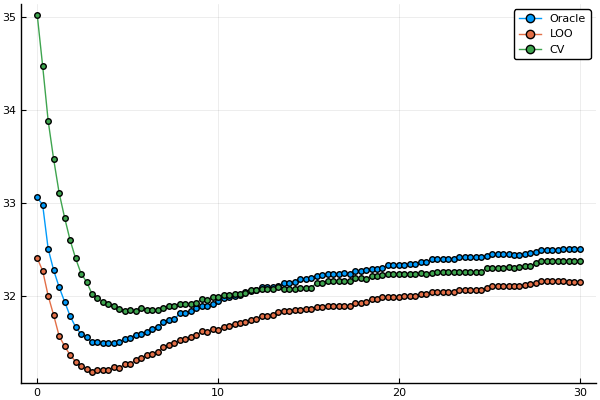

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [202]:
println("SAA:\t", outOR[1], "\t", outOR[1] / full_info - 1)
println("LOO:\t", outOR[argmin(outLOO)], "\t", outOR[argmin(outLOO)]/full_info - 1)
println("OR:\t", minimum(outOR), "\t", minimum(outOR)/full_info - 1)
println("KS:\t", outKS, "\t", outKS/full_info - 1)

plot(alpha_grid, [outOR outLOO/N outCV/N], label=["Oracle" "LOO" "CV"], marker=:circ)
#plot(alpha_grid, [outOR outLOO/N], label=["Oracle" "LOO"], marker=:circ)


  0.312262 seconds (4.05 M allocations: 285.187 MiB, 14.35% gc time)
32.07737611658806	0.12203746123231696


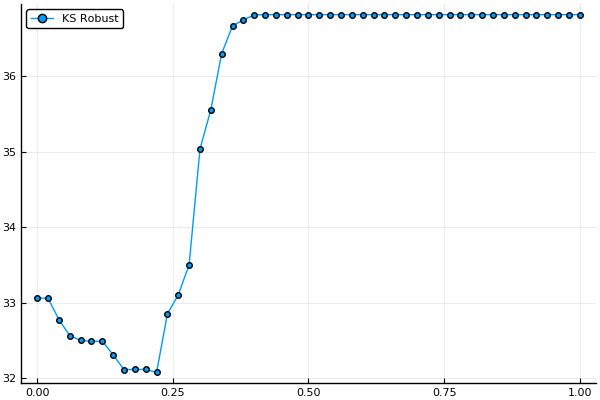

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [143]:
Gamma_grid = range(0, stop=1, length=51)
@time outKS = map(g->JS.zbar(xsKS, csKS, mhats, ps, lams, g), Gamma_grid)
println(minimum(outKS), "\t", minimum(outKS)/full_info -1)
plot(Gamma_grid, outKS, label="KS Robust", marker=:circ)

In [206]:
# Gamma_grid = [sqrt(log(2/delta)/2) for delta in range(.001, stop=.1, length=51)]
# reverse!(Gamma_grid)
Gamma_grid = collect(range(0, stop=sqrt(log(2/.001)/2), length=51))
#JS.zbar(xsKS2, csKS2, mhats, ps, lams, (Gamma_grid, 5))
JS.zbar(xsKS, csKS, mhats, ps, lams, 1000)
#xsKS2[3](mhats[:,1], (Gamma_grid, 5))




36.81923449516717

In [ ]:
### Sanity Checks.  
#  ###Check that xs(alpha) actually minimizes p(\alpha)^T c(alpha)
#  # spot check zLOO(alpha) and ZOR(alpha) against other implementation
#  # do a run for large K.
#  #check that oracle value minimized at bayesian value = 2
#  #do a curve by curve spot check
k0 = 15
alpha0 = 0
palpha_k = JS.shrink(mhats[:, k0]/Nhats[k0], p0, alpha0, Nhats[k0])
xalpha_k = xs[k0](p0, alpha0, mhats[:, k0])

println("palpha_k:\t", palpha_k)
println("x_alphak:\t", xalpha_k)

dot(palpha_k, map(c_ik -> c_ik(9), cs[:, k0])), dot(palpha_k, map(c_ik -> c_ik(10), cs[:, k0]))


# alpha = 2
# palphas = similar(ps)
# for k = 1:K
#     palphas[:, k] = JS.shrink(mhats[:, k]/Nhats[k], p0, alpha, Nhats[k])
# end

JS.zbar(xs, cs, p0, 2, mhats, ps, ones(K))

In [ ]:
### Sanity Checks.  
#  # spot check zLOO(alpha) and ZOR(alpha) against other implementation
#  # do a run for large K.
#  #check that oracle value minimized at bayesian value = 2
#  #do a curve by curve spot check

#JS.zbar(xs, cs, 1.515, mhats, ps, ones(K)) 
JS.zLOObar_unsc(xs, cs, p0, 0.44717265850424653, mhats)

In [ ]:
JS.mse_estimates(mhats, collect(1:d), p0, alpha_grid)

In [ ]:
println( alpha_grid[indmin(outOR)], "\t",  alpha_grid[indmin(outLOO)] )
println(minimum(outOR), "\t", outOR[indmin(outLOO)]/minimum(outOR), "\t", outOR[21]/minimum(outOR))


### Implementing Cross-Validation

In [15]:
using Distributions, Plots, Random
include("../src/JS_SAA_main.jl")
pyplot()

Plots.PyPlotBackend()

In [16]:
K = 20
d = 11
N = 7
Random.seed!(8675309)

#gen an "interesting" distribution of ps still centered at 1/d
p0 = ones(d)/d
ps = rand(Dirichlet(ones(d)), K)
Nhats = rand(Poisson(N), K)
mhats = JS.sim_path(ps, Nhats);

In [ ]:
@time cv_data = split_cv(mhats, 5)

[minimum(sum(cv_data[fold], dims=1)) for fold = 1:5]


In [ ]:
fold = 5
train_data = sum(cv_data[setdiff(1:5, fold)])
test_Nhats = sum(cv_data[fold], dims=1)
Nhat_filt = vec(test_Nhats .> 0)
test_phat = zero(cv_data[fold])
test_phat[:, Nhat_filt] = cv_data[fold][:, Nhat_filt] ./ transpose(test_Nhats[Nhat_filt])

findall(sum(test_phat, dims=1) .< 1)
test_Nhats[13:15]


In [125]:
t = collect(1:5)
push!(t, 1)

6-element Array{Int64,1}:
 1
 2
 3
 4
 5
 1

MethodError: MethodError: no method matching argmin()
Closest candidates are:
  argmin(!Matched::SparseArrays.SparseMatrixCSC) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v0.7/SparseArrays/src/sparsematrix.jl:1904
  argmin(!Matched::AbstractArray; dims) at reducedim.jl:850
  argmin(!Matched::Any) at array.jl:2189